# Housing Prices Competition: Pre-processing and Predictions 🏘️💰📈

<p align="center">
    <a href="https://nbviewer.org/github/KOrfanakis/Housing_Prices_Regression/blob/main/02-Preprocessing_and_Predictions.ipynb">
        <img alt="Made with" src="https://img.shields.io/badge/Render%20with-nbviewer-red.svg">
    </a>
    <br/>
</p>

<br>

<img src="https://images.unsplash.com/photo-1508404140693-f3a1a3e2a85d?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1338&q=80" width = 600>
<center><em>Photo by Annie Spratt (Unsplash)</em></center>

<br>

**Table of Contents**

- [Overview](#Overview)
- [Libraries And Default Parameters](#Libraries-And-Default-Parameters)
- [Getting The Data](#Getting-The-Data)
- [Data Pre-processing](#Data-Pre-processing)
    - [Missing Values](#Missing-Values) <br>
    - [Label Encoding And Factorizing Variables](#Label-Encoding-And-Factorizing-Variables) <br>
    - [Dealing With Outliers](#Dealing-With-Outliers) <br>
    - [Feature Engineering](#Feature-Engineering) <br>
    - [Feature Selection](#Feature-Selection) <br>
        - [Dropping Highly Correlated Variables](#Dropping-Highly-Correlated-Variables) <br>
        - [Droppin Features With Low Variance](#Droppin-Features-With-Low-Variance) <br>
    - [One-hot Encoding](#One-hot-Encoding) <br>
    - [Splitting Back Into Training/Test Sets](#Splitting-Back-Into-Training/Test-Sets)
    - [Scaling](#Scaling)
    - [Creating A Temporary Test Set](#Creating-A-Temporary-Test-Set)
- [Building Machine Learning Models](#Building-Machine-Learning-Models)
    - [Baseline Models](#Baseline-Models) <br>
    - [Model Tuning](#Model-Tuning) <br>
        - [Ridge Regression](#Ridge-Regression) <br>
        - [Lasso Regression](#Lasso-Regression) <br>
        - [SVR](#SVR) <br>
        - [LGBMRegressor](#LGBMRegressor)
    - [Comparison](#Comparison) <br>
    - [Feature Importance](#Feature-Importance)
- [Test Set](#Test-Set)
- [Submission](#Submission)
- [References](#References)
- [Conclusions](#Conclusions)


<br>

# Overview

This notebook is my attempt at the [Housing Prices Competition](https://www.kaggle.com/c/home-data-for-ml-course), one of the most famous competitions on [Kaggle](https://www.kaggle.com/). 

The dataset, compiled by Dean De Cock, contains information about (almost) every aspect of residential homes in Ames, Iowa.  Our **goal** is to predict the final price of a house based on its characteristics. Therefore, it is a typical **regression task** since we need to predict a continuous value. The notebook is (roughly) divided into two main sections:

- The first one is on **pre-processing** our data. In other words, we will convert our (raw) data to a suitable format for Machine Learning (ML) algorithms.
- The second section is on **building ML models** and **evaluating** their predictive performance.

There is a separate notebook on Exploratory Data Analysis (EDA), which you can find [here](https://github.com/KOrfanakis/Housing_Prices_Regression/blob/main/01-Exploratory_Data_Analysis.ipynb). It is clear and concise, so please have a look at it if you are not familiar with the dataset.

<br>

# Libraries And Default Parameters

We start by importing the necessary libraries and setting some parameters for the whole notebook. We will mainly use four Python libraries:

- [Pandas](https://pandas.pydata.org/) for handling and analysing data,
- [Seaborn](https://seaborn.pydata.org/) and [Matplotlib](https://matplotlib.org/) for data visualisation, and
- [Scikit-learn](https://scikit-learn.org/stable/) for building ML models.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
import watermark
%load_ext watermark

# See version of system, Python, and libraries
%watermark -n -v -m -iv

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.0.1

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores   : 4
Architecture: 64bit

seaborn   : 0.11.2
matplotlib: 3.5.1
json      : 2.0.9
numpy     : 1.22.2
pandas    : 1.4.1
watermark : 2.3.0
scipy     : 1.8.0
re        : 2.2.1

sklearn   : 1.0.2
lightgbm  : 3.3.2


In [3]:
pd.set_option('display.precision', 3)

%config InlineBackend.figure_format = 'retina'  # Enable retina display

plt.style.use('fivethirtyeight')
main_color = '#B7C3F3'
edgecolor = '#4F6272'
facecolor = '#f0f0f0'

font_size = 14

plt.rcParams['axes.edgecolor'] = '0.15'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2

plt.rcParams['lines.linewidth'] = 3

random_state = 42

<br>

# Getting The Data

We will use the `read_csv()` method to load the two datasets we created in the first notebook.

In [4]:
train_df = pd.read_csv('Datasets/train_new.csv')
test_df = pd.read_csv('Datasets/test_new.csv')

print('DataFrames loaded successfully!\n')
print('The train set contains {} rows and {} columns'.format(train_df.shape[0], train_df.shape[1]))
print(' The test set contains {} rows and {} columns'.format(test_df.shape[0], test_df.shape[1]))

DataFrames loaded successfully!

The train set contains 1460 rows and 80 columns
 The test set contains 1459 rows and 79 columns


Then, we will **merge** the two DataFrames into one; this DataFrame will be used to pre-process both the training and the test set simultaneously. Note that the combined DataFrame will have NaN in the 'SalePrice' column for all instances of the test set:

In [5]:
all_data = pd.concat([train_df, test_df]).reset_index(drop=True)

print('The combined dataset has {} rows and {} columns'.format(all_data.shape[0], all_data.shape[1]))
print("Number of NaN values in 'SalePrice': ", all_data['SalePrice'].isnull().sum())

The combined dataset has 2919 rows and 80 columns
Number of NaN values in 'SalePrice':  1459


<br> 

# Data Pre-processing

Data pre-processing is the process of converting raw data into a well-readable format that is suitable for building and training ML models.

We will complete this process step-by-step.


<br>

## Missing Values

We have already dealt with missing values in the first notebook. We can check that there are indeed no missing values in the predictor variables of the combined dataset.

In [6]:
X = all_data[all_data.columns.difference(['SalePrice'])]

no_features = (X.isnull().sum(axis=0) != 0).sum()
print('There are {} features with missing values.'.format(no_features))

There are 0 features with missing values.


<br>

## Label Encoding And Factorising Variables

The dataset contains several categorical features, which we need to somehow **encode to numbers** before building any ML model. For ordinal features specifically, we need to encode them so that two nearby values are more similar than two distant values. 

For instance, there are ten categorical features related to condition or quality. After reading the [data_description.txt](https://www.kaggle.com/c/home-data-for-ml-course/data?select=data_description.txt) file, we note that they have the same categories/labels:

| Label 	|     Meaning     	|
|:-----:	|:---------------:	|
|   Ex  	|    Excellent    	|
|   Gd  	|       Good      	|
|   TA  	| Typical/Average 	|
|   Fa  	|       Fair      	|
|   Po  	|       Poor      	|
|  None 	|    No Garage    	|

Ideally, we would like our model to assume that 'Excellent' is slightly better than 'Good' but considerably better than 'Poor'. We can achieve this in two steps:

1) We define a dictionary that maps labels to numbers in a way that preserves the ordering, and <br>
2) Call the `replace()` function on the column and pass the dictionary as the only argument.

In [7]:
condition_dict = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

for column in [
        'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'
]:

    all_data[column] = all_data[column].replace(condition_dict)

We can repeat this process for all other ordinal features. For example, 'LotShape' describes the general shape of a property and can take only four values:

| Label 	|        Meaning       	|
|:-----:	|:--------------------:	|
|  Reg  	|        Regular       	|
|  IR1  	|  Slightly irregular  	|
|  IR2  	| Moderately Irregular 	|
|  IR3  	|       Irregular      	|

It appears there is some ordinality since a regular shape is, in theory, more desired than an irregular one.

In [8]:
lot_shape_dict = {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3}
all_data['LotShape'] = all_data['LotShape'].replace(lot_shape_dict)

Let's take a closer look at the masonry veneer type ('MasVnrType'):

In [9]:
mas_gb = train_df.groupby(['MasVnrType'])
mas_counts = mas_gb.size().to_frame(name='Count')

mas_counts.join(train_df.groupby('MasVnrType')['SalePrice'].median()).sort_values(by='SalePrice')

,Count,SalePrice
MasVnrType,,
BrkCmn,15,139000.0
None,872,143125.0
BrkFace,445,181000.0
Stone,128,246839.0


As [Erik Bruin](https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda#header) pointed out, there seems to be a significant difference between "common brick/none" and the other types of masonry. We can assume that there is indeed ordinality in this variable.

In [10]:
all_data['MasVnrType'] = all_data['MasVnrType'].replace({
    'None': 0,
    'BrkCmn': 0,
    'BrkFace': 1,
    'Stone': 2
})

We will not go into details about the rest of the features that need encoding.

In [11]:
all_data['GarageFinish'] = all_data['GarageFinish'].replace({'None': 0,
                                                             'Unf': 1,
                                                             'RFn': 2,
                                                             'Fin': 3})

all_data['BsmtExposure'] = all_data['BsmtExposure'].replace({'None': 0,
                                                             'No': 1,
                                                             'Mn': 2,
                                                             'Av': 3,
                                                             'Gd': 4})

for col in ['BsmtFinType1', 'BsmtFinType2']:
    all_data[col] = all_data[col].replace({'None': 0,
                                           'Unf': 1,
                                           'LwQ': 2,
                                           'Rec': 3,
                                           'BLQ': 4,
                                           'ALQ': 5,
                                           'GLQ': 6})

all_data['Functional'] = all_data['Functional'].replace({'Sal': 0,
                                                         'Sev': 1,
                                                         'Maj2': 2,
                                                         'Maj1': 3,
                                                         'Mod': 4,
                                                         'Min2': 5,
                                                         'Min1': 6,'Typ': 7})

all_data['LandSlope'] = all_data['LandSlope'].replace({'Sev': 0,
                                                       'Mod': 1,
                                                       'Gtl': 2})

all_data['PavedDrive'] = all_data['PavedDrive'].replace({'N': 0,
                                                         'P': 1,
                                                         'Y': 2})

Finally, we can use the same technique to encode binary features.

In [12]:
all_data['CentralAir'] = all_data['CentralAir'].map({'N': 0, 'Y': 1})
all_data['Street'] = all_data['Street'].map({'Grvl': 0, 'Pave': 1})

<br>

## Dealing With Outliers

The [documentation](http://jse.amstat.org/v19n3/decock.pdf) for the Ames Housing Data states that there are **outliers present** in the training set and suggests we plot 'SalePrice' against 'GrLivArea' (i.e. 'Above ground living area square feet') to see them:

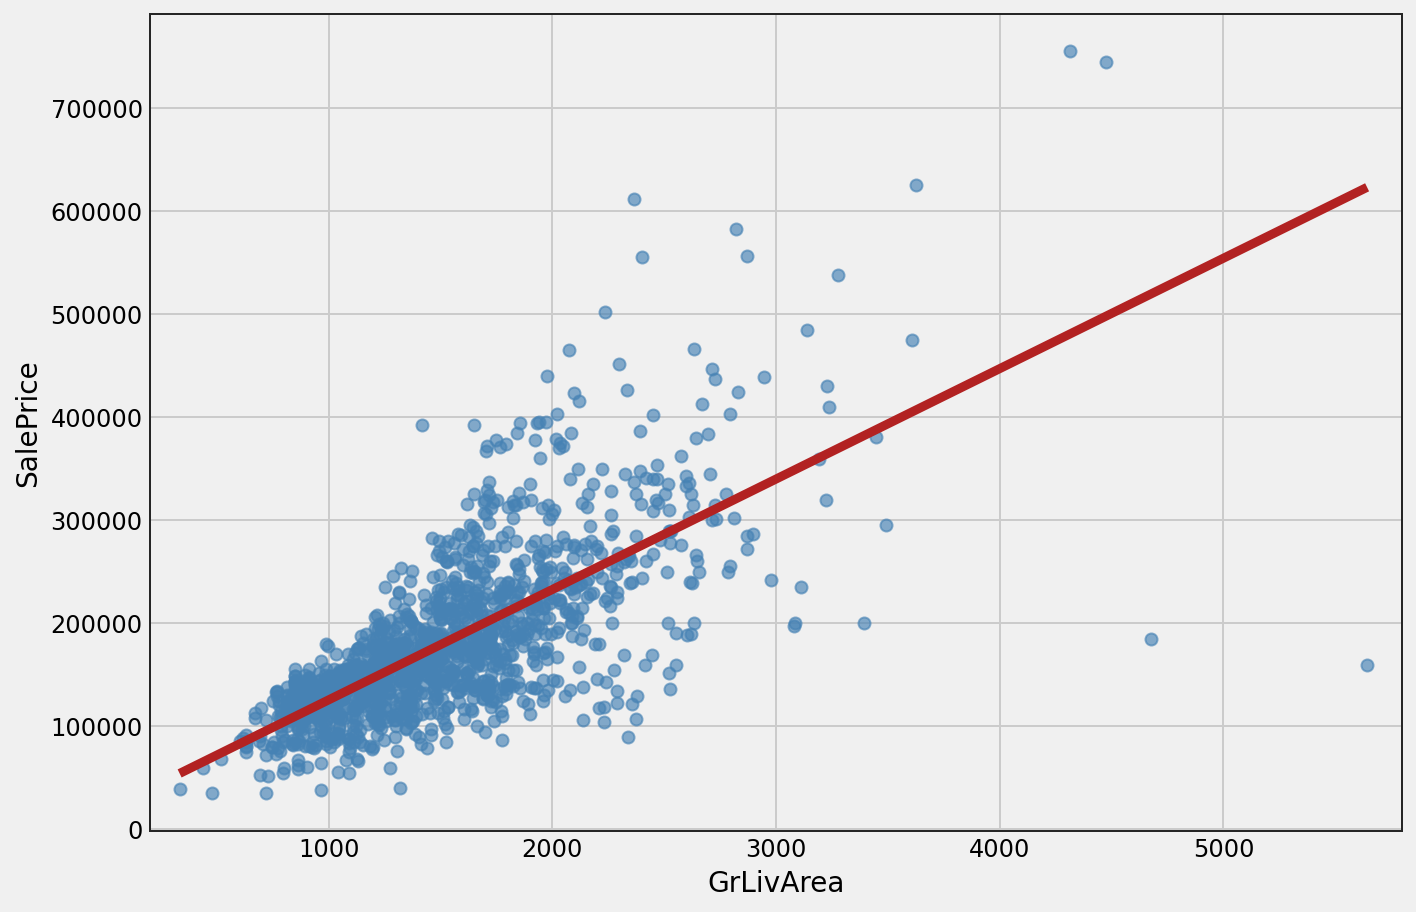

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.regplot(x='GrLivArea',
            y='SalePrice',
            data=train_df,
            ci=None,
            color='steelblue',
            scatter_kws={'alpha': 0.65},
            line_kws={'color': 'firebrick'},
            ax=ax)

ax.set_xlim([200, 5800]);

The two points at the lower right part of the plot (extremely large area for a low price) could be classified as outliers. We will follow the documentation and remove points '*more than 4,000 square feet from the data set*'. By doing that, we can increase the correlation of 'GrLivArea' with 'SalePrice'.

In [14]:
corr_before = train_df[['GrLivArea', 'SalePrice']].corr().loc['GrLivArea', 'SalePrice']

outliers_idx = train_df[train_df['GrLivArea'] > 4_000].index
all_data_outliers = all_data.drop(outliers_idx)

corr_after = all_data_outliers[['GrLivArea', 'SalePrice']].corr().loc['GrLivArea', 'SalePrice']

print('Correlation')
print('Before: ', np.round(corr_before, 3))
print(' After: ', np.round(corr_after, 3))

Correlation
Before:  0.709
 After:  0.721


However, 'GrLivArea' is not the only feature with outliers. The boxplots in the first notebook helped us identify  features with extreme outliers. As a reminder, we will visualise the boxplots again, but only for the features we will treat:

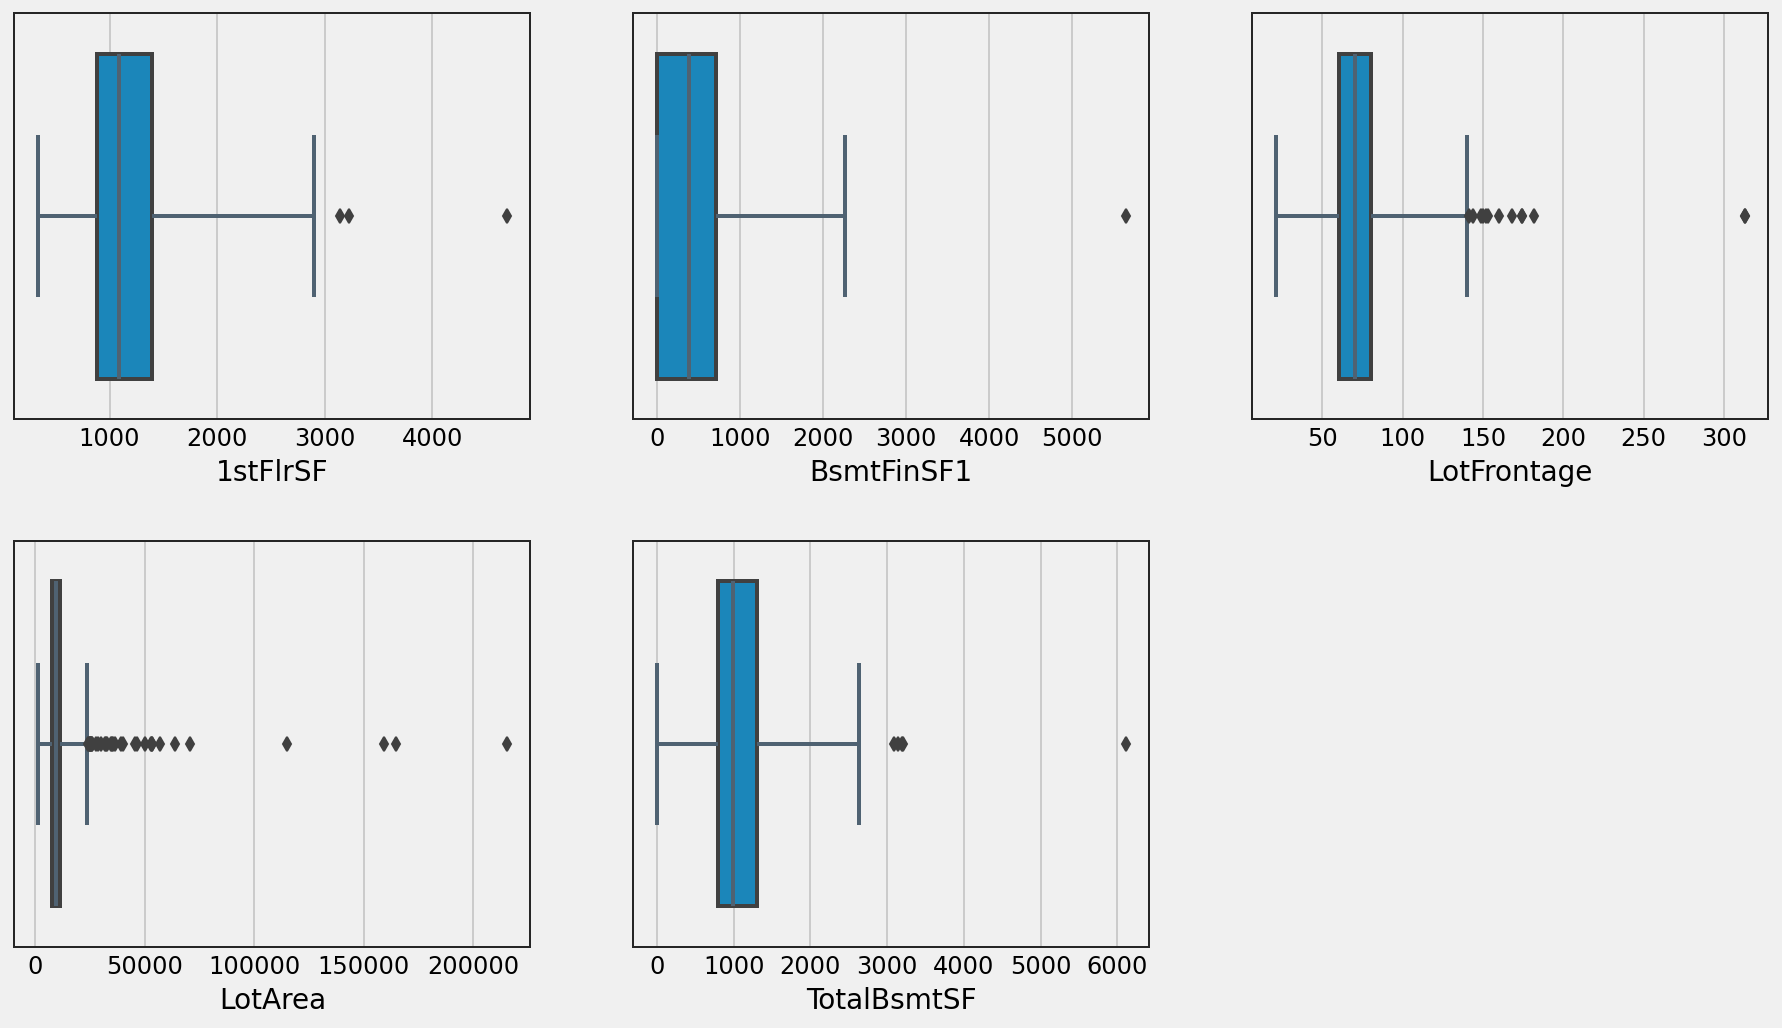

In [15]:
out_col = ['1stFlrSF', 'BsmtFinSF1', 'LotFrontage', 'LotArea', 'TotalBsmtSF']

fig = plt.figure(figsize=(14, 8), facecolor='#f0f0f0')

for index, col in enumerate(out_col):

    plt.subplot(2, 3, index + 1)
    sns.boxplot(
        x=col,
        data=train_df,
        whis=3,
        linewidth=2,
        medianprops={'color': edgecolor},
        capprops={'color': edgecolor},
        whiskerprops={'color': edgecolor},
    )

plt.subplots_adjust(hspace=0.3);

For each one, we will remove all outliers based on a particular threshold value.

In [16]:
idx_drop = []
idx_drop.extend(train_df[train_df['GrLivArea'] > 4_000].index)
idx_drop.extend(train_df[train_df['1stFlrSF'] > 3_000].index)
idx_drop.extend(train_df[train_df['BsmtFinSF1'] > 4_000].index)
idx_drop.extend(train_df[train_df['LotFrontage'] > 200].index)
idx_drop.extend(train_df[train_df['LotArea'] > 100_000].index)
idx_drop.extend(train_df[train_df['TotalBsmtSF'] > 5_000].index)

idx_drop = list(set(idx_drop))

all_data = all_data.drop(idx_drop)
all_data.reset_index(drop=True);

<br>

## Feature Engineering

Feature Engineering is the process of using domain knowledge to create useful new features from the existing ones. This process aims to **improve the predictive performance** of our ML models. 

<br>

### Total Number of Bathrooms

The first feature we will create is 'TotalBath', which combines the four individual features related to bathrooms. I followed [Erik](https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda#header)'s suggestion and assigned a smaller weight (0.5) to features related to half bathrooms.

Correlation with 'SalePrice':

   TotalBath: 0.63

Individual Features
   FullBath: 0.56
   BsmtFullBath: 0.23
   HalfBath: 0.29
   BsmtHalfBath: -0.04


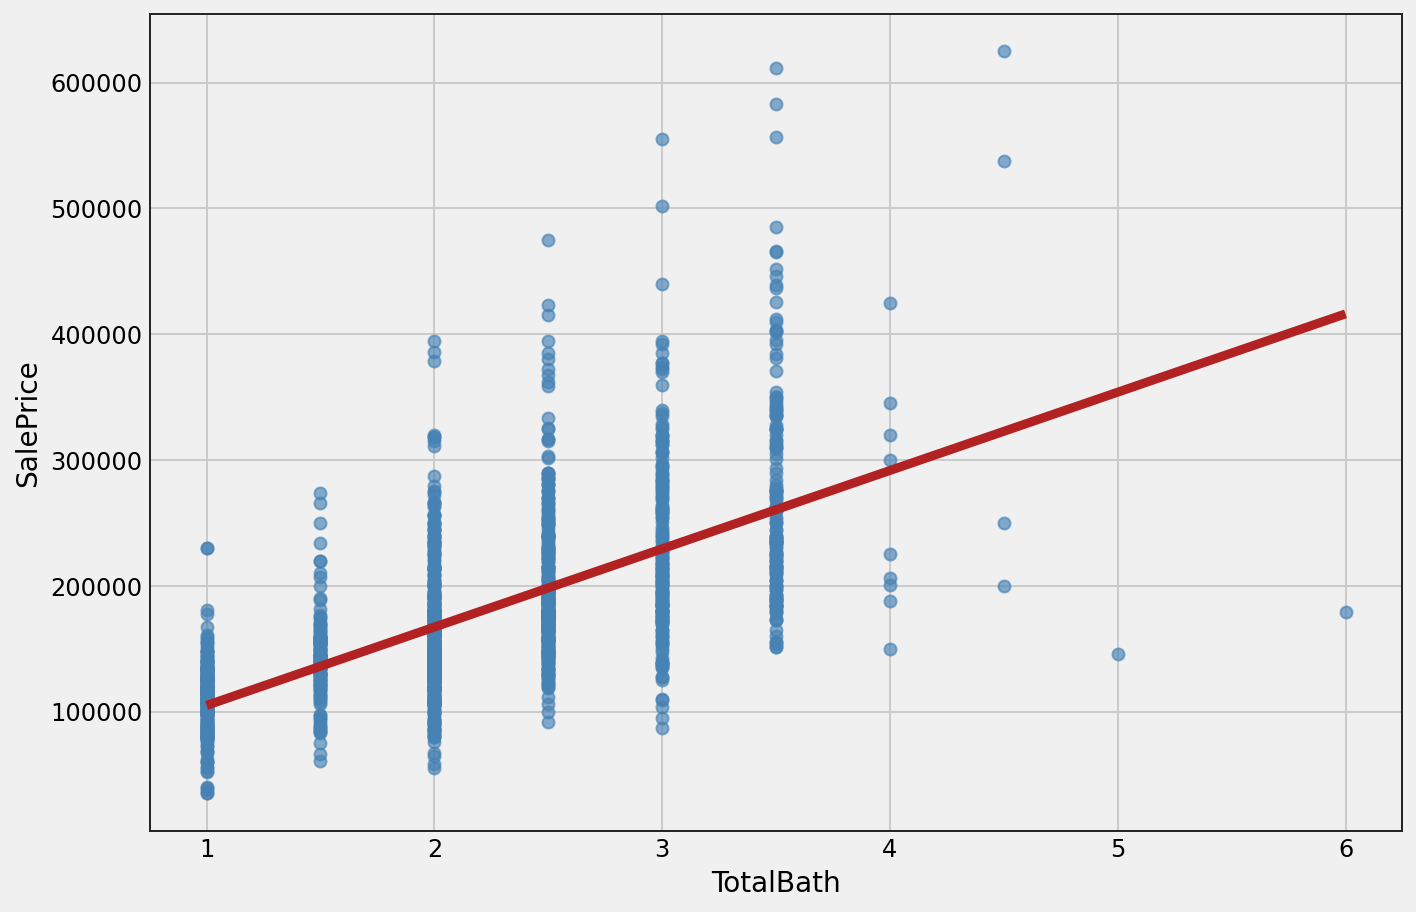

In [17]:
all_data['TotalBath'] = all_data['FullBath'] + all_data['BsmtFullBath'] + 0.5 * all_data['HalfBath'] + 0.5 * all_data['BsmtHalfBath']

print("Correlation with 'SalePrice':\n")

cor = all_data[['TotalBath', 'SalePrice']].corr().loc['TotalBath', 'SalePrice']
print('   ' + 'TotalBath' + ': ' + str(np.round(cor, 2)))

print("\nIndividual Features")
for col in ['FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath']:
    cor = all_data[[col, 'SalePrice']].corr().loc[col, 'SalePrice']
    print('   ' + col + ': ' + str(np.round(cor, 2)))

fig, ax = plt.subplots(figsize=(10, 7))

sns.regplot(x='TotalBath',
            y='SalePrice',
            data=all_data,
            ci=None,
            color='steelblue',
            scatter_kws={'alpha': 0.65},
            line_kws={'color': 'firebrick'},
            ax=ax);

The new feature has a higher positive correlation with 'SalePrice' compared to the four constituent features.

<br>

### Binning Neighborhood

Using Pandas’ `groupby()` method, we can visualise each neighbourhood's median and mean 'SalePrice' value. 

In [18]:
neighbour_median = train_df.groupby('Neighborhood')['SalePrice'].median()
neighbour_median = neighbour_median.to_frame().sort_values(by='SalePrice', ascending=True)

neighbour_mean = train_df.groupby('Neighborhood')['SalePrice'].mean()
neighbour_mean = neighbour_mean.to_frame().sort_values(by='SalePrice', ascending=True)

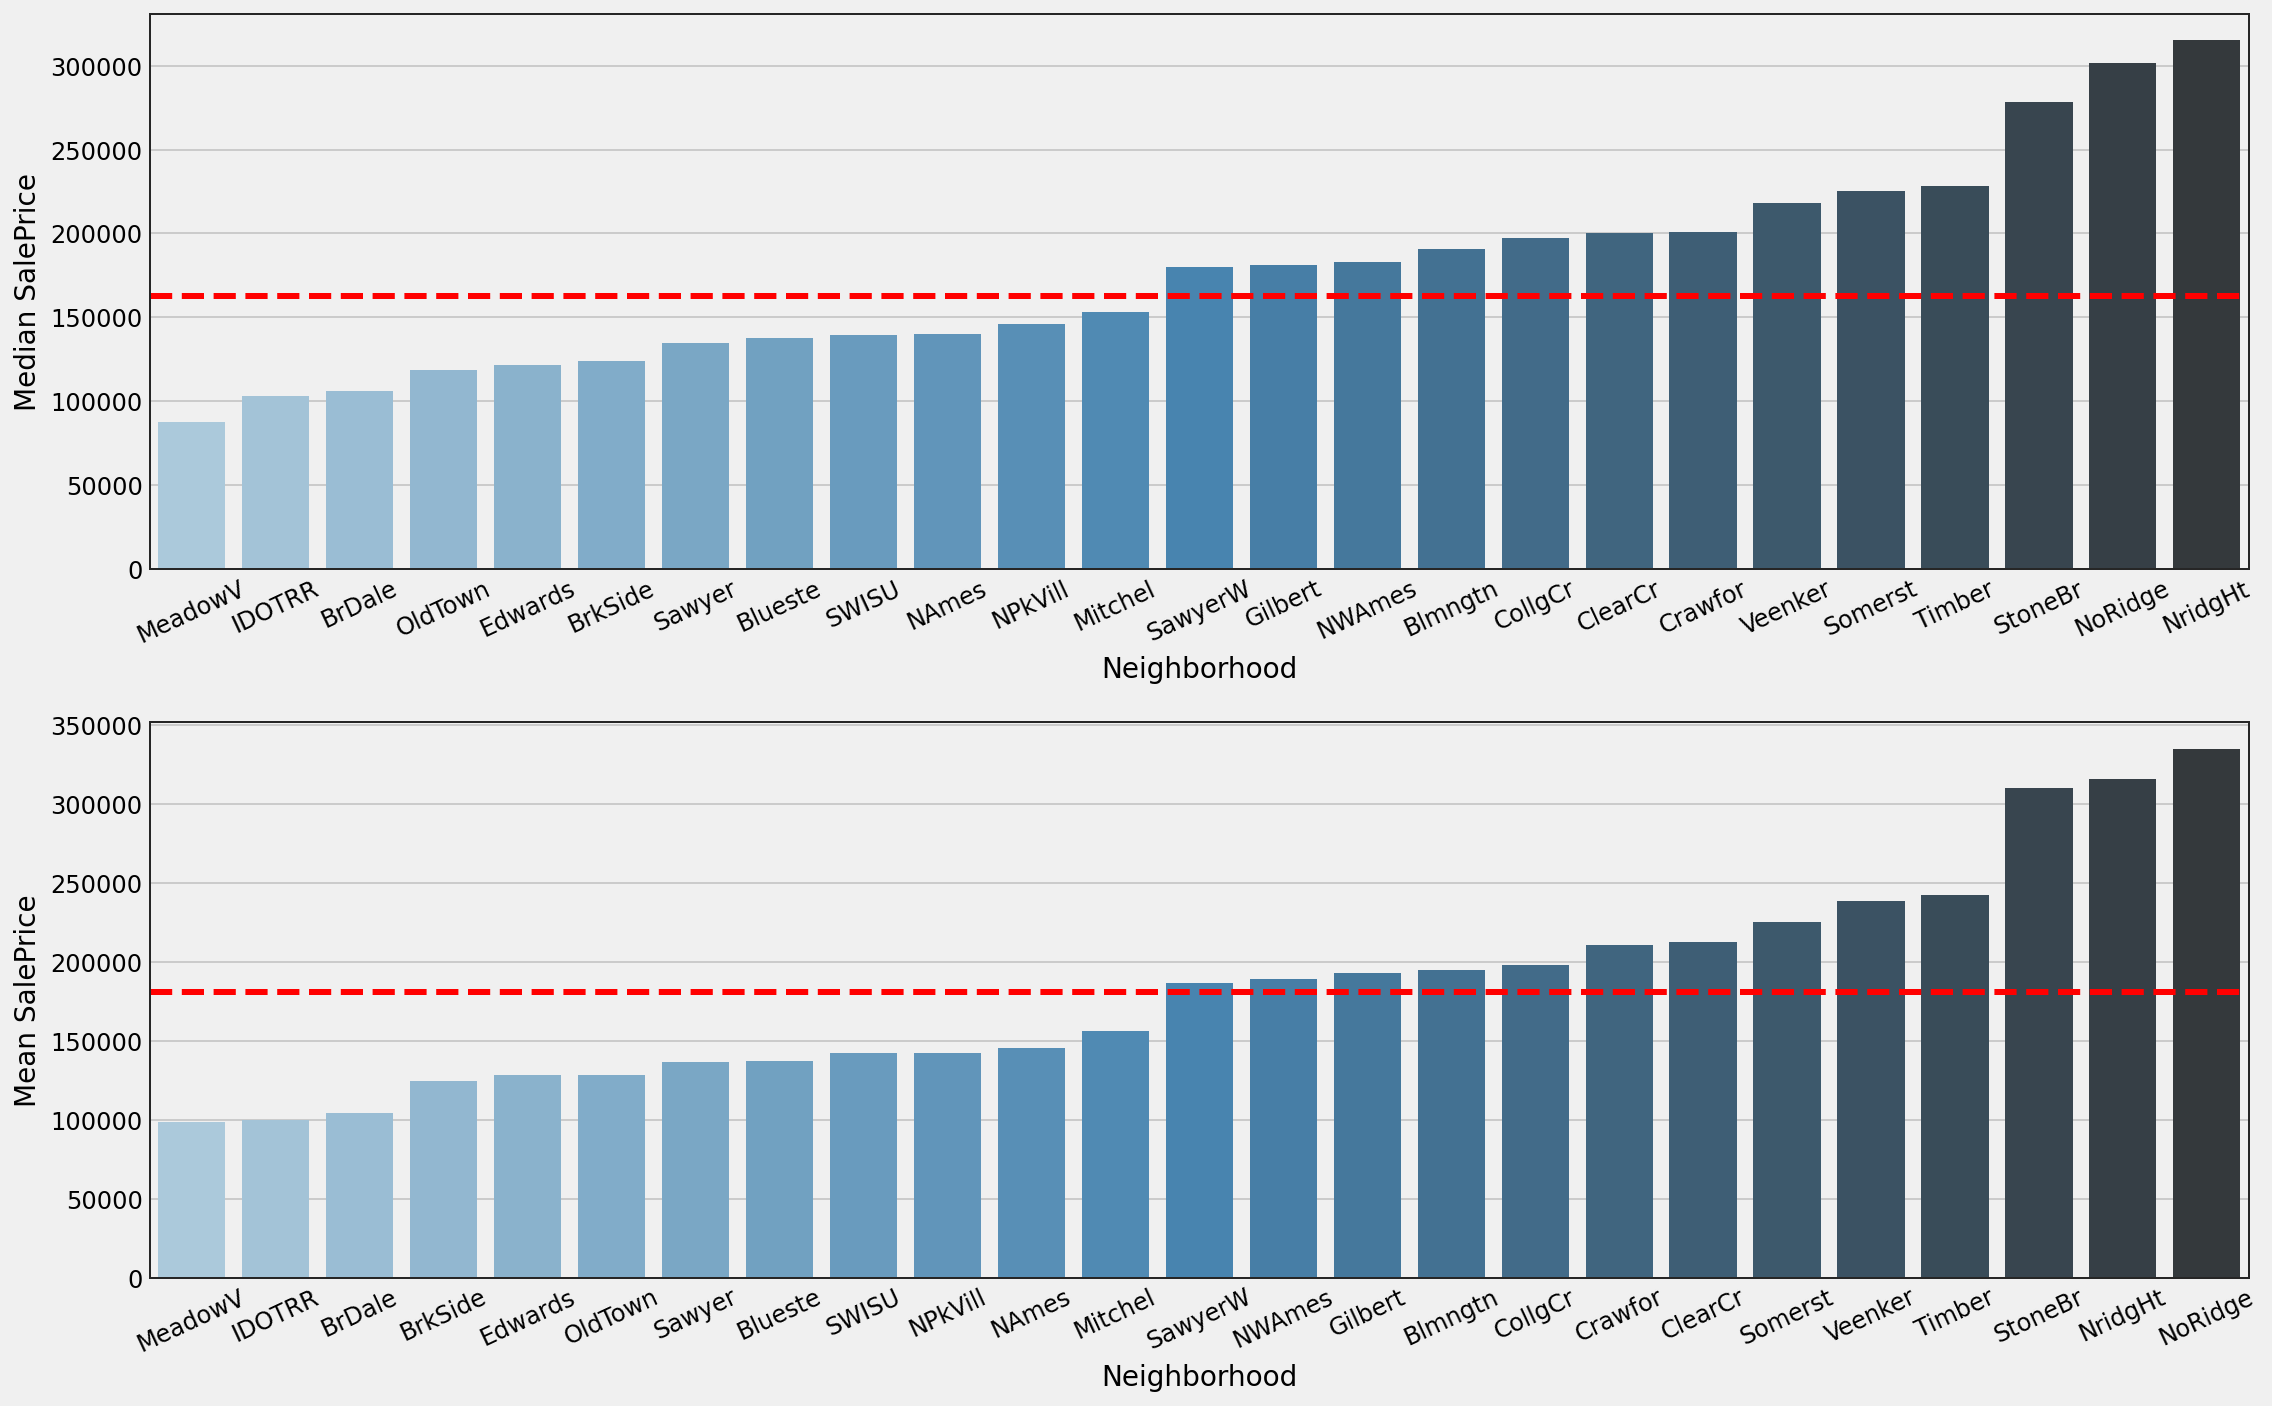

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

sns.barplot(x=neighbour_median.index,
            y=neighbour_median['SalePrice'],
            palette='Blues_d',
            ax=ax1)

sns.barplot(x=neighbour_mean.index,
            y=neighbour_mean['SalePrice'],
            palette='Blues_d',
            ax=ax2)

ax1.axhline(y=train_df['SalePrice'].median(), color='red', ls='--')
ax2.axhline(y=train_df['SalePrice'].mean(), color='red', ls='--')

ax1.set_ylabel('Median SalePrice')
ax2.set_ylabel('Mean SalePrice')

for ax in [ax1, ax2]:
    ax.tick_params(axis='x', rotation=25)

plt.tight_layout();

Three neighbourhoods (NridgHt, NoRidge, and StoneBr) have a considerably higher median and mean 'SalePrice' than the rest. The distinction of the three relatively poor neighbourhoods (MeadowV, IDOTRR, and BrDale) from the rest is less clear, but we will still consider them as one category. Finally, the remaining neighbourhoods will be categorised in one of two categories, based on whether their mean/median 'SalePrice' is above or below the value of the whole dataset (red dashed line).

In [20]:
def label_neighborhoods(row):
    if row in ['StoneBr', 'NridgHt', 'NoRidge']:
        return 3
    if row in [
            'Timber', 'Somerst', 'Veenker', 'Crawfor', 'CollgCr', 'ClearCr',
            'Blmngtn', 'NWAmes', 'Gilbert', 'SawyerW'
    ]:
        return 2
    elif row in ['MeadowV', 'IDOTRR', 'BrDale']:
        return 0
    else:
        return 1


all_data['Neigh_Rich'] = all_data['Neighborhood'].apply(lambda row: label_neighborhoods(row))
train_df['Neigh_Rich'] = train_df['Neighborhood'].apply(lambda row: label_neighborhoods(row))
neigh_gb = train_df.groupby(['Neigh_Rich'])
neigh_counts = neigh_gb.size().to_frame(name='Count')

neigh_counts.join(train_df.groupby('Neigh_Rich')['SalePrice'].median()).sort_values(by='SalePrice')

,Count,SalePrice
Neigh_Rich,,
0,70,100500.0
1,655,135000.0
2,592,192750.0
3,143,306000.0


<br>

### Total Square Feet

Finally, we will combine features 'GrLivArea' and 'TotalBsmtSF' into a single one, 'TotalSqFeet'. The new feature adds up the living space above and below ground.

Correlation with 'SalePrice':

   TotalSqFeet: 0.82

Individual Features
   GrLivArea: 0.72
   TotalBsmtSF: 0.64


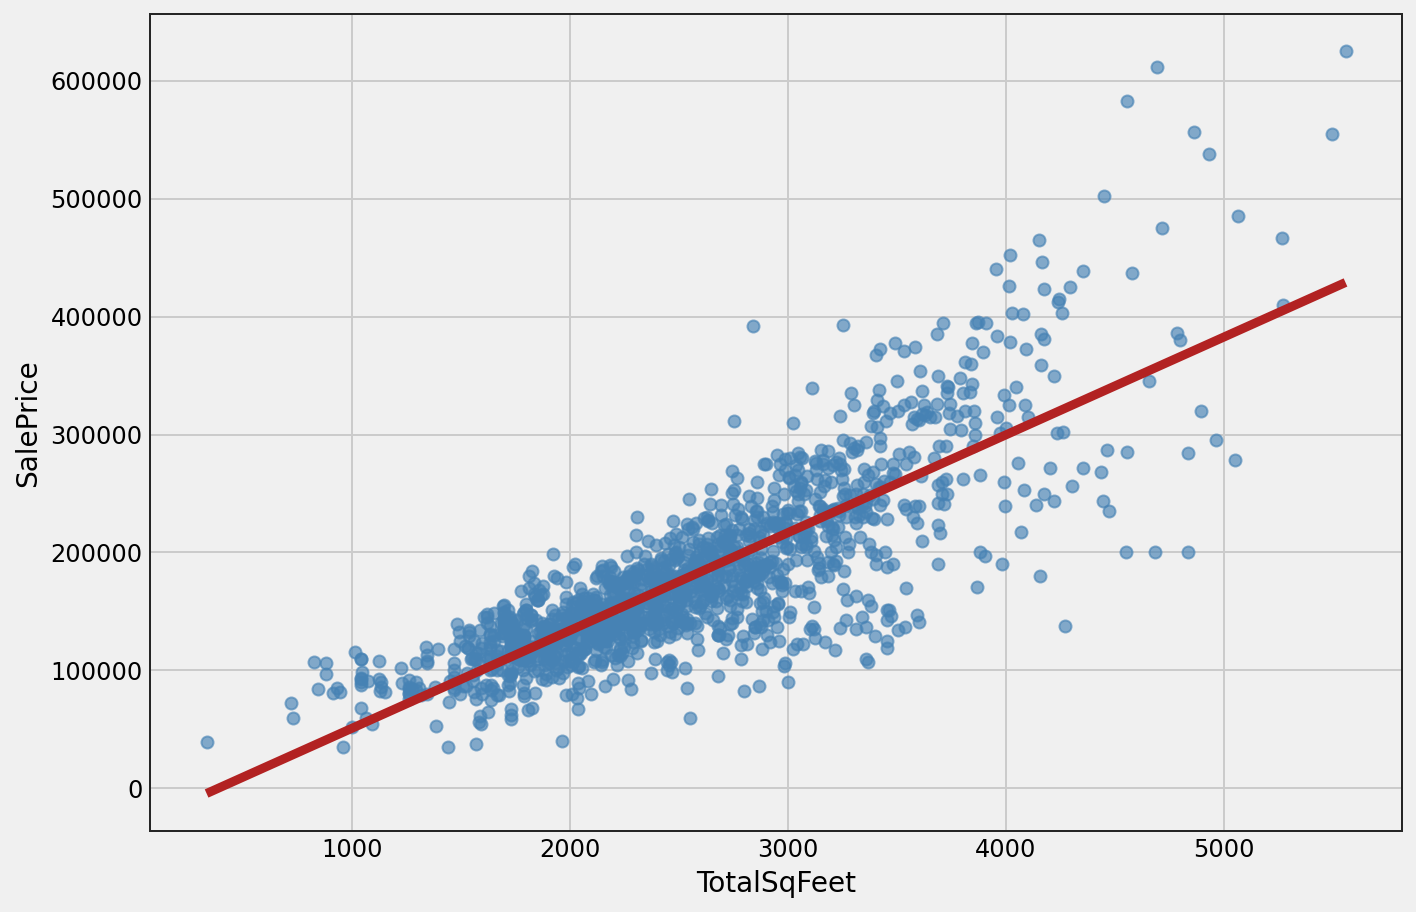

In [21]:
all_data['TotalSqFeet'] = all_data['GrLivArea'] + all_data['TotalBsmtSF']

print("Correlation with 'SalePrice':\n")

cor = all_data[['TotalSqFeet', 'SalePrice']].corr().loc['TotalSqFeet', 'SalePrice']
print('   ' + 'TotalSqFeet' + ': ' + str(np.round(cor, 2)))

print("\nIndividual Features")
for col in ['GrLivArea', 'TotalBsmtSF']:
    cor = all_data[[col, 'SalePrice']].corr().loc[col, 'SalePrice']
    print('   ' + col + ': ' + str(np.round(cor, 2)))

fig, ax = plt.subplots(figsize=(10, 7))

sns.regplot(x='TotalSqFeet',
            y='SalePrice',
            data=all_data,
            ci=None,
            color='steelblue',
            scatter_kws={'alpha': 0.65},
            line_kws={'color': 'firebrick'},
            ax=ax);

<br>

## Feature Selection

### Dropping Highly Correlated Variables

[EDA](https://github.com/KOrfanakis/Housing_Prices_Regression/blob/main/01-Exploratory_Data_Analysis.ipynb) showed that four pairs of features exhibit **multicollinearity**. We can plot a new heatmap to see if there are new pairs after outlier removal and feature engineering. Again, only correlations > 0.75 are highlighted.

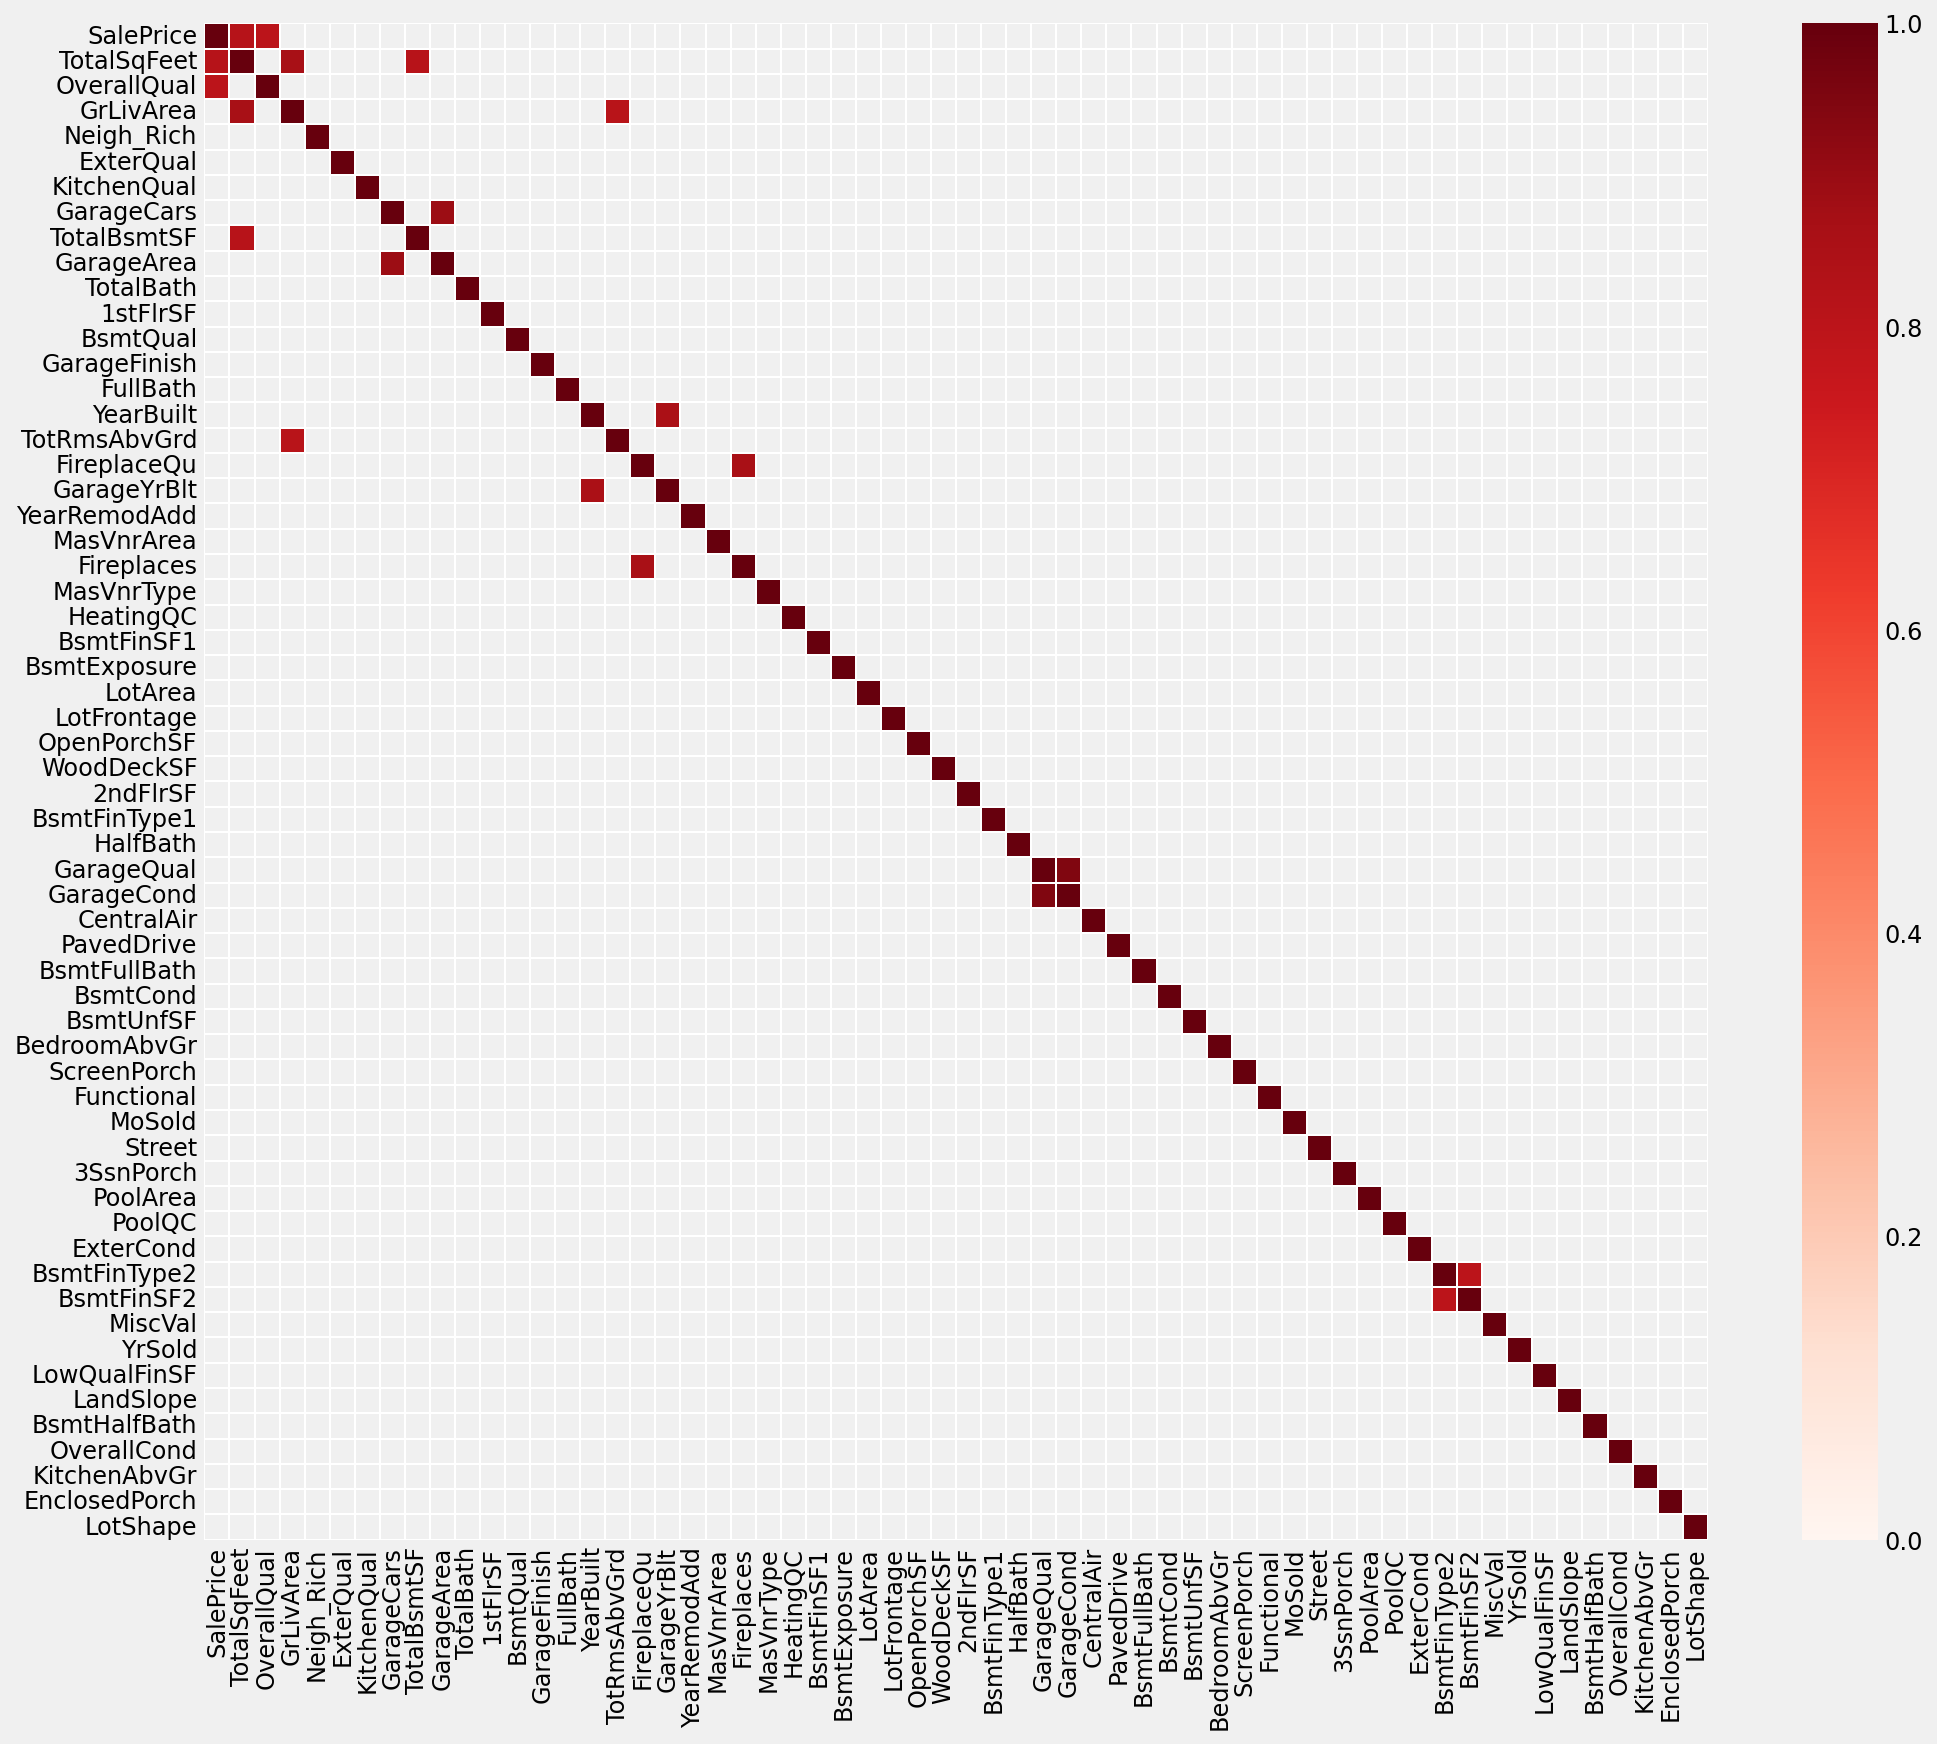

In [22]:
numeric_fts = all_data.select_dtypes(exclude=['object'])
correlations = numeric_fts.corr()
correlations = correlations[['SalePrice']].sort_values(by=['SalePrice'],
                                                       ascending=False)
indeces = correlations.index

corr_matrix = numeric_fts.corr().loc[indeces, indeces]
matrix = np.triu(corr_matrix)

plt.figure(figsize=(15, 13))

sns.heatmap(corr_matrix,
            mask=corr_matrix < 0.80,
            vmin=0,
            linewidth=1,
            cmap='Reds');

Our pre-processing procedure so far has indeed led to four **extra multicollinear pairs**. From each pair, we will drop the feature that exhibits the smaller correlation with 'SalePrice'.

In [23]:
cols_drop = ['GrLivArea', 'TotalBsmtSF', 'GarageArea', 'GarageYrBlt', 'Fireplaces', 'GarageCond']
all_data.drop(cols_drop, axis=1, inplace=True)

### Droppin Features With Low Variance

Additionally, [EDA](https://github.com/KOrfanakis/Housing_Prices_Regression/blob/main/01-Exploratory_Data_Analysis.ipynb) confirmed that some features display **low variance**, which means that they are close to being constant. Therefore, they do not provide any information to a model for learning the patterns in the data, and they **should be removed**.

I have written a simple for loop for identifying such features based on a threshold value (0.95 in our case, i.e. features in which 95% of instances have the same value):

In [24]:
thd = 0.95
cols_drop = []

for column in all_data.drop('SalePrice', axis=1):

    most_freq_value = all_data[column].value_counts(normalize=True).iloc[0]
    if (most_freq_value > thd):
        cols_drop.append(column)
        print('{}: {}% same value'.format(column, np.round(most_freq_value, 3)))

all_data.drop(cols_drop, axis=1, inplace=True)
print('\nFeatures with low variance dropped successfully!')

Street: 0.996% same value
Utilities: 1.0% same value
LandSlope: 0.953% same value
Condition2: 0.99% same value
RoofMatl: 0.986% same value
Heating: 0.985% same value
LowQualFinSF: 0.986% same value
KitchenAbvGr: 0.954% same value
3SsnPorch: 0.987% same value
PoolArea: 0.996% same value
PoolQC: 0.997% same value
MiscFeature: 0.965% same value
MiscVal: 0.965% same value

Features with low variance dropped successfully!


<br>
<br>

The last two pre-processing steps we need to complete are:

- **One-hot encoding** the **categorical** features, and 
- **Scaling** the **continuous (numerical)** features.

Before we proceed, we need to categorise features based on their type.

In [25]:
categorical = all_data.select_dtypes(include=['object']).columns
numeric = all_data.select_dtypes(exclude=['object']).columns

ordinal = [
    'FireplaceQu', 'GarageQual', 'BsmtQual', 'BsmtCond', 'KitchenQual',
    'ExterQual', 'ExterCond', 'HeatingQC', 'LotShape', 'GarageFinish',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'Functional',
    'CentralAir', 'PavedDrive', 'OverallCond', 'OverallQual', 'BsmtFullBath',
    'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
    'GarageCars', 'TotalBath', 'Neigh_Rich'
]

binary = ['CentralAir']

continuous = [
    col for col in all_data.select_dtypes(exclude=['object'])
    if col not in (ordinal or binary)
]

continuous.remove('SalePrice')

print('Number of Categorical columns: ', len(categorical))
print('Number of Numeric columns: ', len(numeric))
print(' - Ordinal: ', len(ordinal))
print(' - Binary: ', len(binary))
print(' - Continuous: ', len(continuous))

Number of Categorical columns:  18
Number of Numeric columns:  46
 - Ordinal:  28
 - Binary:  1
 - Continuous:  17


<br>

## One-hot Encoding

Apart from label encoding (which we used for ordinal features), **one-hot encoding** is another technique for converting categorical variables into a suitable form for ML algorithms. One-hot encoding substitutes every categorical column with n columns (n: the number of categories), one for each of its categories. Every instance/row gets 1 for the column it corresponds to and 0 for the remaining n -1 columns.

As an example, imagine we have a feature 'Color' with three categories:

| Color |
|-------|
| red   |
| green |
| blue  |

One-hot encoding will transform this feature into the following matrix:

| Color_red | Color_green | Color_blue |
|:---------:|:-----------:|:----------:|
|     1     |      0      |      0     |
|     0     |      1      |      0     |
|     0     |      0      |      1     |

<br>

In our case, we will use the `get_dummies()` method:

In [26]:
all_data_before = all_data.copy()

all_data = pd.get_dummies(all_data, columns=categorical, drop_first=True)
print('One-hot encoding completed!\n')
print('Shape before: ', all_data_before.shape)
print(' Shape after: ', all_data.shape)

One-hot encoding completed!

Shape before:  (2909, 64)
 Shape after:  (2909, 183)


The number of features exploded from 64 to 183! 

If we were to continue as of now, one ML algorithm (LGBM Regressor) would output an error saying "*Do not support special JSON characters in feature name*". We can easily fix it with a regular expression (See [GitHub Issue](https://github.com/awslabs/autogluon/issues/399)).

In [27]:
all_data = all_data.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

<br>

## Splitting Back Into Training/Test Sets

We need to split the combined dataset back into a training and a test set:

In [28]:
idx = all_data['SalePrice'].notnull().sum()

# Training Set
train_df = all_data[:idx]

X_train = train_df.drop('SalePrice', 1)
y_train = np.log1p(train_df['SalePrice'])

# Test Set
test_df = all_data[idx:]

X_test = test_df.drop('SalePrice', axis=1)

Remember that **log-transforming** the target variable **changes its range of values** (10.46 to 13.346).

In [29]:
y_train.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
SalePrice,1450.0,12.019,0.395,10.46,11.775,12.0,12.27,13.346


<br>

## Scaling

**Feature scaling** is a technique used to normalise the range of features in a dataset. Some algorithms are sensitive to feature scaling (e.g. SVMs), while others are invariant (e.g. Random Forests).

In our case, we need to standardise the continuous features. We will use scikit-learn's `StandardScaler()` transformer, which standardises features by subtracting the mean and dividing by the standard deviation. This transformation results in features with **zero mean** and **unit variance**.

In [30]:
scaler = StandardScaler()
scaler.fit(X_train[continuous])

X_train[continuous] = scaler.transform(X_train[continuous])
X_test[continuous] = scaler.transform(X_test[continuous])

Notice that the transformer is fitted using the training set before being applied on both sets. This practice protects us from **data leakage**.

<br>

## Creating A Temporary Test Set

Unfortunately, we do not have access to the 'SalePrice' values of the test set (y_test) since the complete test set is only accessible for direct testing online. Therefore, to evaluate our models on unseen data, we will **create a small test set** consisting of 200 instances (~ 14%) of the training set.

In [31]:
X_train_full = X_train.copy()
y_train_full = y_train.copy()

X_test_full = X_test.copy()

X_test = X_train.iloc[1250:]
y_test = y_train.iloc[1250:]

X_train = X_train.iloc[:1250]
y_train = y_train.iloc[:1250]

<br>

# Building Machine Learning Models

Before we start training any ML model, we need to select a performance measure. Kaggle uses the **Mean Absolute Error** (**MAE**) to construct its leaderboard, so we will also use it in this notebook. It is defined as:

<img src="https://latex.codecogs.com/gif.latex?MAE&space;=&space;\frac{1}{n}&space;\sum_{i=1}^{n}|y_{i}&space;-&space;\hat&space;y_{i}|" title="MAE = \frac{1}{n} \sum_{i=1}^{n}|y_{i} - \hat y_{i}|" />

where, $y_{1}, y_{2}, . . . , y_{n} $ are the observed values, <br>
$\hat{y}_{1}, \hat{y}_{2}, . . . , \hat{y}_{n}$ are the predicted values, and <br>
$n$ is the total number of instances.

In [32]:
scoring = 'neg_mean_absolute_error'

<br>

## Baseline Models

When creating ML models, it is essential to have a **baseline** by which we can compare the performance of the model we are building. With regression tasks, the best way to establish a baseline is to assume a model that only predicts the mean or median of the target variable. In our case, using the mean and median ‘SalePrice’, we can get two baseline performances. 

In [33]:
print('Baseline using the')
y_pred = np.full(len(y_train), y_train.mean())
mae_base_mean = mean_absolute_error(y_train, y_pred)
print('-   Mean: ', np.round(mae_base_mean, 3))

y_pred = np.full(len(y_train), y_train.median())
mae_base_median = mean_absolute_error(y_train, y_pred)
print('- Median: ', np.round(mae_base_median, 3))

Baseline using the
-   Mean:  0.307
- Median:  0.307


Using their **default parameters**, we can calculate the **(baseline) performance** of four different estimators/regressors on the training set. This step will enable us to see how tuning improves each of these models.

The regressors are:

1) Ridge Regressor, <br>
2) Lasso Regressor, <br>
3) Support Vector Regressor (SVR), and <br>
4) LGBM Regressor.

For more information on how these regressors work, please refer to [Refs. 1 and 2](#References).

For the baseline models, we will use the default parameters for each regressor and evaluate performance by calculating the MAE using **k-fold cross-validation**.

The idea behind k-fold cross-validation, which is illustrated in the following figure, is simple: it splits the (training) set into k subsets/folds, trains the models using k-1 folds and evaluates the model on the remaining one fold. This process is repeated until every fold is tested once.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width = 400>
<center>Taken from the official documentation on scikit-learn's website</center>

<br>

K-fold cross-validation leads to less biased models since it ensures that every instance from the original training set will be used both for training and testing.

We can implement cross-validation by using the `cross_val_score()` method from scikit-learn. We will use k = 5 folds.

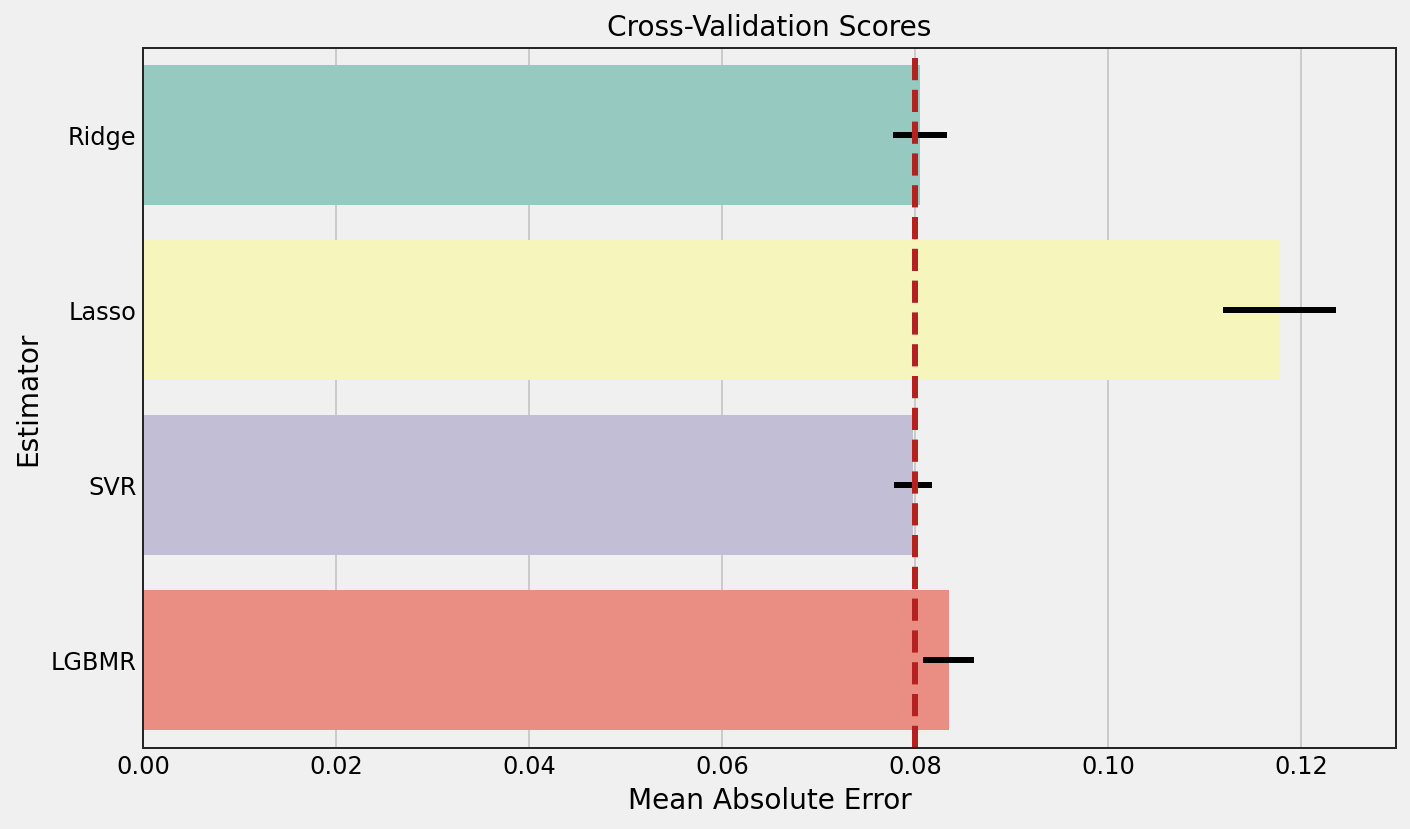

In [34]:
# Step 1: create a list containing all estimators with their default parameters
names = ['Ridge', 'Lasso', 'SVR', 'LGBMR']

estimators = [
    Ridge(random_state=random_state),
    Lasso(0.05, random_state=random_state),
    SVR(),
    LGBMRegressor(verbose=-1, random_state=random_state)
]

# Step 2: calculate the cv mean and standard deviation for each one of them
cv_base_mean, cv_std = [], []
for est in estimators:

    cv = cross_val_score(est,
                         X_train,
                         y_train,
                         scoring=scoring,
                         cv=5,
                         n_jobs=-1)
    cv_base_mean.append(-cv.mean())
    cv_std.append(cv.std())

# Step 3: create a dataframe and plot the mean with error bars
cv_baseline = pd.DataFrame({
    'Estimator': names,
    'CV-Means': cv_base_mean,
    'CV-Errors': cv_std
})

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x='CV-Means',
            y='Estimator',
            data=cv_baseline,
            palette='Set3',
            orient='h',
            **{'xerr': cv_std},
            ax=ax)

ax.set_xlabel('Mean Absolute Error')
ax.set_title('Cross-Validation Scores')
ax.axvline(x=0.08, color='firebrick', linestyle='--');

It seems that the best baseline estimators are **SVR** and **Ridge**, with CV scores around 0.08 (red dashed line). Additionally, using these estimators **improves predictive performance by a factor ~4** compared to the naive baseline models based on the mean and median values.

<br>

## Model Tuning

We are ready to tune hyperparameters using **grid search** and see if performance improves. Grid search (provided by scikit-learn's `GridSeachCV`) 'exhaustively generates candidate models from a grid of parameter values specified with the `param_grid` parameter'. It then evaluates each model using cross-validation, thus allowing us to determine the optimal values for all hyperparameters.

We will not go into detail about the hyperparameters of each model. If you want to know more, please visit the corresponding documentation.

<br>

We write a simple performance reporting function (inspired by [Ken](https://www.kaggle.com/kenjee/titanic-project-example)'s kernel). The function will:
- Print the best score,
- Print the best parameters (i.e. the parameters that lead to the best score), and
- Append each CV score to a list (we will use it for plotting later).

In [35]:
cv_tuned = {}

def Model_Performance(model_name, model):

    print('\n', model_name)
    print('-----------------------------------------')
    print('        Best Score: ', str(np.round(-model.best_score_, 3)))
    print('   Best Parameters: ', str(model.best_params_))

    arg_min = np.argmin(model.cv_results_['rank_test_score'])
    scores_list = []
    for i in [
            'split0_test_score', 'split1_test_score', 'split2_test_score',
            'split3_test_score', 'split4_test_score'
    ]:
        scores_list.append(-model.cv_results_[i][arg_min])

    cv_tuned[model_name] = scores_list

<br>

### Ridge Regression

In [36]:
ridge = Ridge(random_state=random_state)

param_grid = {'alpha': [0.001, 0.1, 1, 10, 100, 1000]}

ridge_grid = GridSearchCV(ridge,
                          param_grid=param_grid,
                          cv=5,
                          scoring=scoring,
                          verbose=True,
                          n_jobs=-1)
best_grid_ridge = ridge_grid.fit(X_train, y_train)

Model_Performance('Ridge', best_grid_ridge)

Fitting 5 folds for each of 6 candidates, totalling 30 fits

 Ridge
-----------------------------------------
        Best Score:  0.079
   Best Parameters:  {'alpha': 10}


<br>

### Lasso Regression

In [37]:
ls = Lasso(random_state=random_state)

param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

ls_grid = GridSearchCV(ls,
                       param_grid=param_grid,
                       cv=5,
                       scoring=scoring,
                       verbose=True,
                       n_jobs=-1)
best_grid_ls = ls_grid.fit(X_train, y_train)

Model_Performance('Lasso', best_grid_ls)

Fitting 5 folds for each of 6 candidates, totalling 30 fits

 Lasso
-----------------------------------------
        Best Score:  0.079
   Best Parameters:  {'alpha': 0.0001}


<br>

### SVR

In [38]:
svr = SVR()

param_grid = {
    'kernel': ['rbf'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'coef0': [0, 1, 10],
    'C': [0.001, 0.1, 1, 10],
    'epsilon': [0.001, 0.01, 0.1, 1]
}

svr_grid = GridSearchCV(svr,
                        param_grid=param_grid,
                        cv=5,
                        scoring=scoring,
                        verbose=True,
                        n_jobs=-1)
best_grid_svr = svr_grid.fit(X_train, y_train)

Model_Performance('SVR', best_grid_svr)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits

 SVR
-----------------------------------------
        Best Score:  0.074
   Best Parameters:  {'C': 1, 'coef0': 0, 'degree': 2, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}


<br>

### LGBMRegressor

In [39]:
lgbm = LGBMRegressor(verbose=-1, random_state=random_state)
param_grid = {
    'boosting_type': ['gbdt'],
    'n_estimators': [50, 100, 1000],
    'num_leaves': [31],
    'max_depth': [5, 10, 50],
    'learning_rate': [0.001, 0.01, 0.1],
    'feature_fraction': [0.4, 0.6, 0.8],
    'min_data_in_leaf': [5, 10, 20],
}

grid_lgbm = GridSearchCV(lgbm,
                         param_grid,
                         cv=5,
                         scoring=scoring,
                         verbose=True,
                         n_jobs=-1)

best_grid_lgbm = grid_lgbm.fit(X_train, y_train)

Model_Performance('LGBMRegressor', best_grid_lgbm)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

 LGBMRegressor
-----------------------------------------
        Best Score:  0.078
   Best Parameters:  {'boosting_type': 'gbdt', 'feature_fraction': 0.4, 'learning_rate': 0.01, 'max_depth': 5, 'min_data_in_leaf': 20, 'n_estimators': 1000, 'num_leaves': 31}


<br>

## Comparison

After performing cross-validation on the best set of parameters for each algorithm, we can now compare their performance **before** and **after** hyperparameter tuning: 

In [40]:
cv_tuned_mean = [
    np.mean(list(cv_tuned.items())[i][1]) for i in range(len(cv_tuned))
]

cv_total = pd.DataFrame({'Baseline': cv_base_mean,
                         'Tuned Performance': cv_tuned_mean},
                        index=names)

cv_total.style.highlight_min(color='lightskyblue', axis=1).format('{:.3f}')

,Baseline,Tuned Performance
Ridge,0.081,0.079
Lasso,0.118,0.079
SVR,0.080,0.074
LGBMR,0.083,0.078


Tuning indeed **improved** performance for all models! SVR has the lowest CV score (~ 0.074), while the remaining estimators have a similar score (~0.079).

<br>

We can also use a boxplot to compare the CV scores for all models (Orhan's [notebook](https://www.kaggle.com/orhankaramancode/ensemble-stacked-regressors-92-acc/notebook#Final-Preprocessing-Steps) gave me this idea). The number on top of each box indicates the median.

In [41]:
colors = ['#7798AB', '#4D5061', '#FFA987', '#724E91', '#C297B8', '#FE4A49']
model_names = [list(cv_tuned.items())[i][0] for i in range(len(cv_tuned))]
scores = [list(cv_tuned.items())[i][1] for i in range(len(cv_tuned))]
score_medians = [np.round(np.median(list(cv_tuned.items())[i][1]), 4) for i in range(len(cv_tuned))]

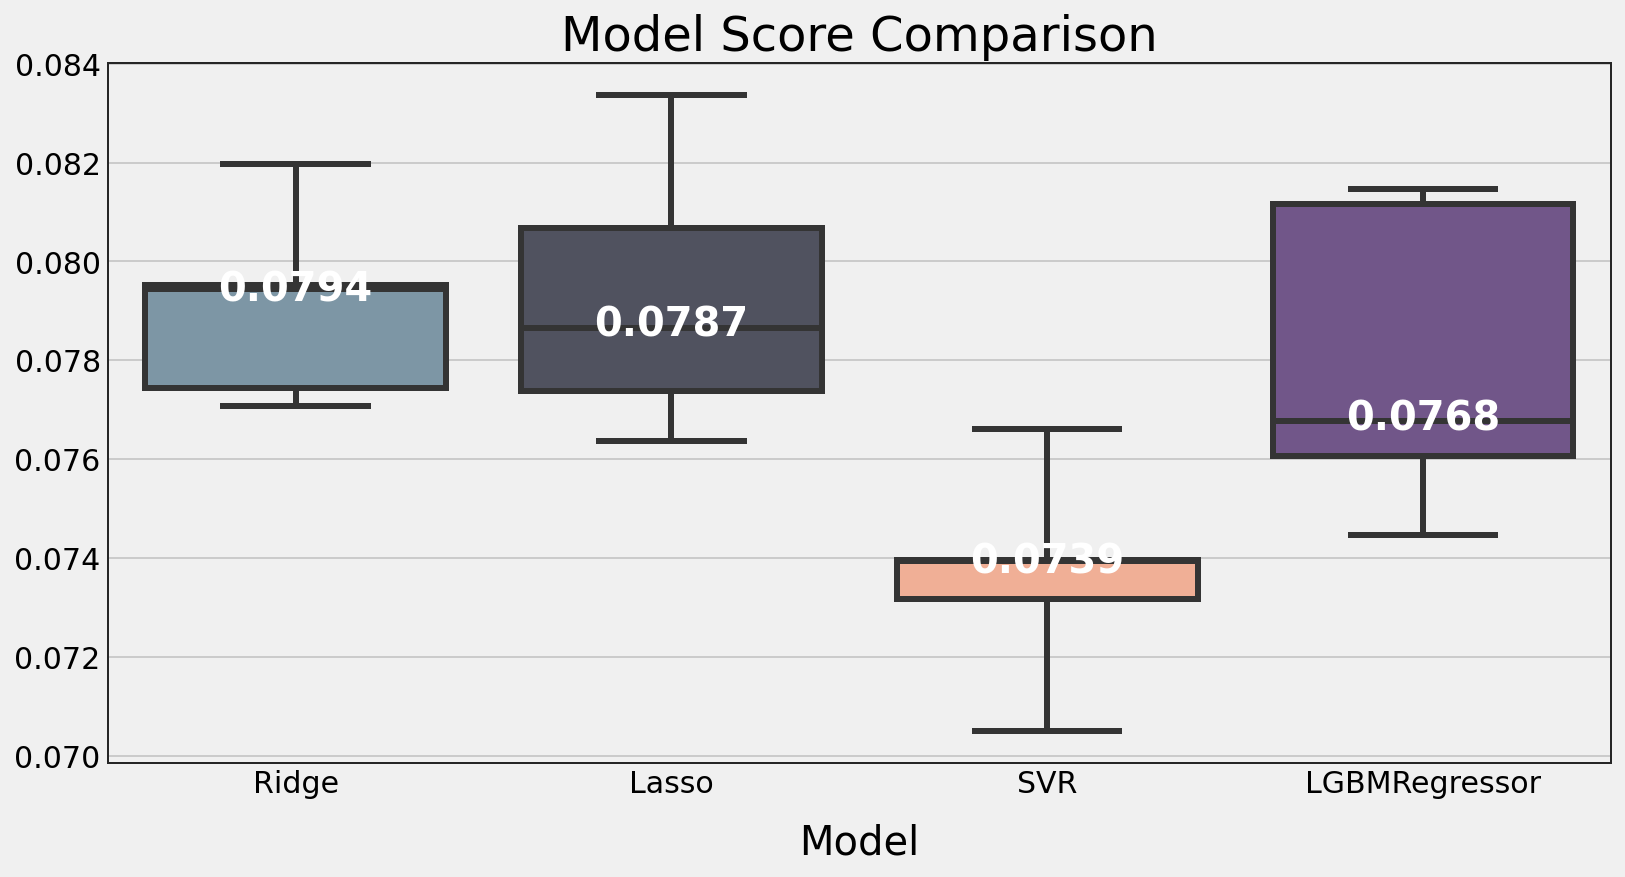

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title('Model Score Comparison', size=24)
sns.boxplot(data=pd.DataFrame(cv_tuned), whis=5, palette=colors, ax=ax)

for xtick in ax.get_xticks():
    ax.text(xtick,
            score_medians[xtick] - 0.0002,
            score_medians[xtick],
            horizontalalignment='center',
            size=20,
            color='w',
            weight='bold')

plt.xlabel('Model', size=20, labelpad=12)
plt.tick_params(axis='both', labelsize=15);

<br>

## Feature Importance

The LGBM Regressor allows us to measure and visualise the relative **importance** of each feature. We will only show the 30 most important features (we can show more/less by changing the `n_features_vis` variable).

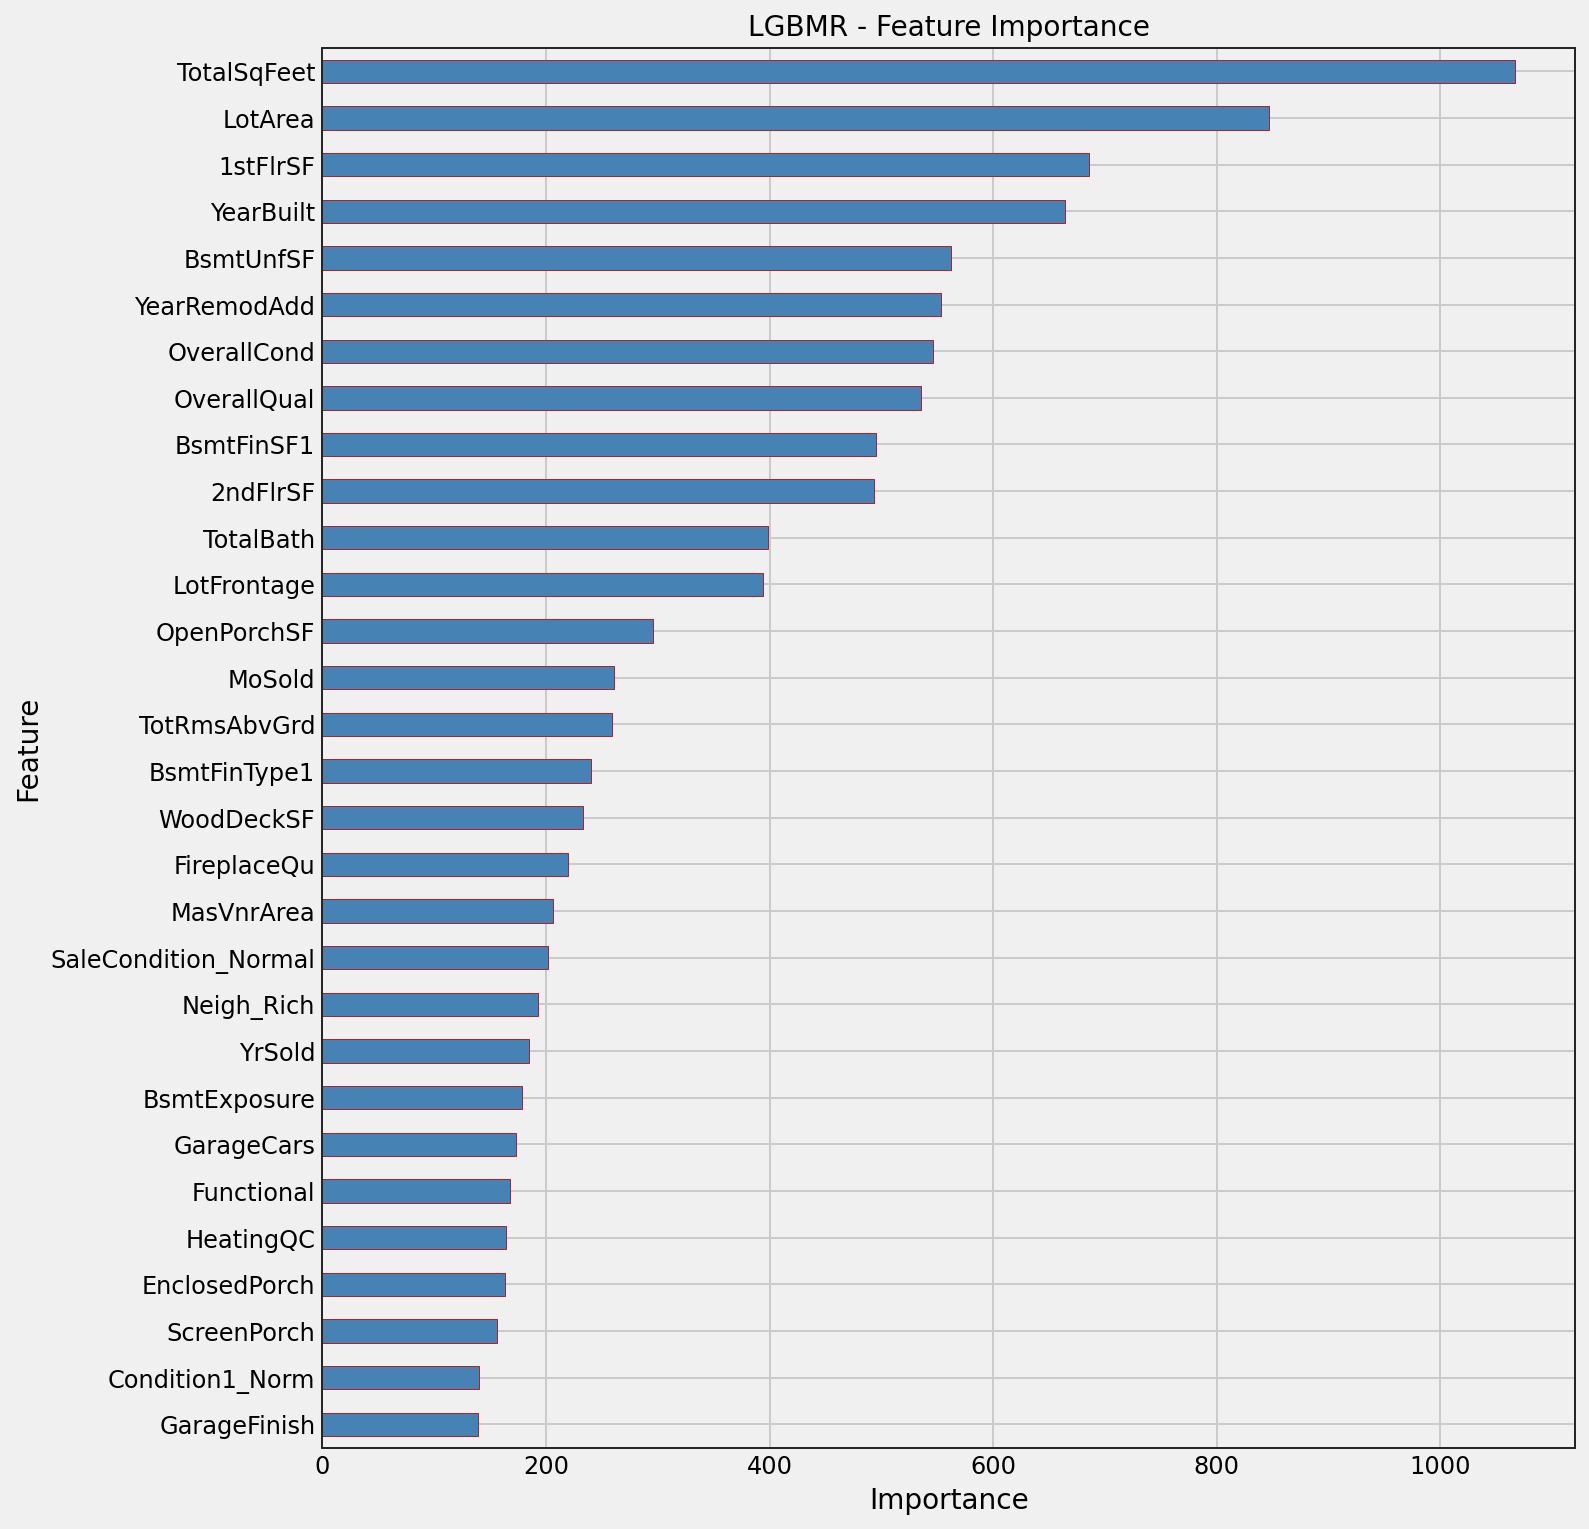

In [43]:
n_features_vis = 30
est = best_grid_lgbm.best_estimator_

feat_imp = pd.DataFrame({'Feature': X_train.columns,
                         'Importance': np.round(est.feature_importances_, 4)})
feat_imp = feat_imp.sort_values('Importance', ascending=False).set_index('Feature')
feat_imp = feat_imp.head(n_features_vis).iloc[::-1]

fig, ax = plt.subplots(figsize=(10, 12))

feat_imp.plot.barh(color='steelblue',
                   edgecolor='firebrick',
                   legend=False,
                   ax=ax)

ax.set(title='LGBMR - Feature Importance', xlabel='Importance');

**'TotalSqFeet'**, the feature we engineered, is the most **important feature**, followed by 'LotArea'. The other two features we engineered, 'TotalBath' and 'NeighRich', are also in the top 30 most important features. Feature engineering proved quite helpful in our case. 

<br>

# Test Set

Now is the time to evaluate the optimised models on **unseen data**. For this purpose, we will use the test set we created earlier ('[Creating A Temporary Test Set](#Creating-A-Temporary-Test-Set)' Section).

In [44]:
best_estimators = [
    best_grid_ridge.best_estimator_, best_grid_ls.best_estimator_,
    best_grid_svr.best_estimator_, best_grid_lgbm.best_estimator_
]

test_scores = []
for i, est in enumerate(best_estimators):
    est.fit(X_train, y_train)
    y_pred = est.predict(X_test)

    mae_test = mean_absolute_error(y_test, y_pred)
    test_scores.append(mae_test)

pd.DataFrame({
    'Algorithm': names,
    'Train CV MAE': cv_tuned_mean,
    'Test MAE': test_scores
})

,Algorithm,Train CV MAE,Test MAE
0,Ridge,0.079,0.080
1,Lasso,0.079,0.079
2,SVR,0.074,0.075
3,LGBMR,0.078,0.079


All models display a similar performance on unseen data (MAE on the test set is ~1.3% higher than the training set), which indicates that there is **no overfitting**.

<br>

Note that so far, we have been using the logarithm of 'SalePrice'. We can revert to the actual value and re-estimate the errors.

In [45]:
test_scores = []
for i, est in enumerate(best_estimators):
    est.fit(X_train, y_train)
    y_pred = est.predict(X_test)

    mae_test = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
    test_scores.append(np.round(mae_test, 1))

pd.DataFrame({'Algorithm': names, 'Test MAE': test_scores})

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


,Algorithm,Test MAE
0,Ridge,13888.3
1,Lasso,13702.0
2,SVR,12818.2
3,LGBMR,13657.2


<br>

# Submission

Finally, we need to create a CSV with predictions for each model to be used for submission. However, we will use the **full training set** in this case as the temporary test set we created has served its purpose. 

In [46]:
for i in range(len(best_estimators)):
    est = best_estimators[i]
    est.fit(X_train_full, y_train_full)

    sub_df = pd.read_csv('Datasets/sample_submission.csv')

    y_pred = est.predict(X_test_full)
    y_pred_trans = np.expm1(y_pred)

    sub_df['SalePrice'] = y_pred_trans
    sub_df.to_csv('Submission_Files\{}.csv'.format(names[i]), index=False)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


<br>

The results are: 

| Model 	|  Score  	|
|:-----:	|:-------:	|
| Ridge 	| 13270.7 	|
| Lasso 	| 13406.0 	|
|  SVR  	| 12788.1 	|
| LGBMR 	| 13832.0 	|

**SVR** is the **best model** with a MAE ~12788, leading to the **94th position** (Top 1%) on the leaderboard (as of 11/11/2021).

<br>

# References

I used several sources, but most notably:

1) [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) by Aurélien Géron

2) [Practical Statistics for Data Scientists, 2nd Edition](https://www.oreilly.com/library/view/practical-statistics-for/9781492072935/), by Peter Bruce, Andrew Bruce and Peter Gedeck

<br>

The following kernels helped me a lot in my analysis (especially during pre-processing):

3) [House prices: Lasso, XGBoost, and a detailed EDA](https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda#header) (Version 56) by [Erik Bruin](https://www.kaggle.com/erikbruin), 

4) [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) (Version 60) by [Serigne](https://www.kaggle.com/serigne), 

5) [Data Science Workflow TOP 2% (with Tuning)](https://www.kaggle.com/angqx95/data-science-workflow-top-2-with-tuning) (Version 39) by [aqx](https://www.kaggle.com/angqx95),

6) [Ensemble | Stacked Regressors | ~92% Acc. |](https://www.kaggle.com/orhankaramancode/ensemble-stacked-regressors-92-acc/output) (Version 19) by [Orhan](https://www.kaggle.com/orhankaramancode) <br>


<br>

# Conclusions

Our notebook just came to an end! 🎉🎉

As a brief conclusion, we could say that:

- We used several techniques for **pre-processing our data** (removing outliers, feature engineering, etc.). It might feel tedious and less enjoyable than training ML models; however, it is  an important step in any ML workflow.

- We selected four regressors (Ridge, Lasso, SVR, and LGBMR), evaluated their baseline performance, tuned their hyperparameters, and re-evaluated the performance of these optimised regressors. After submitting the predictions of all models, we found out that the **tuned SVR** has the best performance achieving a **mean absolute error of ~12788**, placing us in the **94th position** on the leaderboard (**Top 1%**). 

<br>